# 导入数据，测试坐标转换

In [24]:
import numpy as np
import nibabel as nib
import scipy.linalg as lin
import matplotlib.pyplot as plt

def xyz2mni(affine, v):
    v1 = np.append(v, 1)
    return affine.dot(v1)[ : -1]

def mni2xyz(affine, v):
    v1 = np.append(v, 1)
    return lin.solve(affine, v1)[ : -1]

t1_fn = "t1_y.nii.gz"
bold_fn = "bold_y.nii.gz"

t1_raw = nib.load(t1_fn)
print("T1轴方向:", nib.aff2axcodes(t1_raw.affine))
t1_raw = nib.as_closest_canonical(t1_raw)
bold_raw = nib.load(bold_fn)
print("BOLD轴方向:", nib.aff2axcodes(bold_raw.affine))
bold_raw = nib.as_closest_canonical(bold_raw)

t1_data = t1_raw.get_fdata()
bold_data = bold_raw.get_fdata()

# convert BOLD XYZ coordinates to MNI space
v_mni = xyz2mni(bold_raw.affine, [60, 27, 23])
# convert MNI space to T1 XYZ coordinates
v_t1 = mni2xyz(t1_raw.affine, v_mni)
# convert MNI space back to BOLD XYZ coordinates
v_bold = mni2xyz(bold_raw.affine, v_mni)

print(v_mni, v_t1, v_bold, sep = "\n")

T1轴方向: ('P', 'S', 'R')
BOLD轴方向: ('L', 'A', 'S')
[ 57.58471612 -49.86389532  12.81094249]
[146.08952035  83.39995722 131.27462646]
[60. 27. 23.]


# 观察数据

In [25]:
# a = 100
# plt.imshow(t1_data[a, :, :], cmap='gray', origin='lower', vmin=0, vmax=2000)    # 看到的是冠状面
# plt.show()

# plt.imshow(t1_data[:, a, :], cmap='gray', origin='lower', vmin=0, vmax=2000)    # 水平面
# plt.show()

# plt.imshow(t1_data[:, :, a], cmap='gray', origin='lower', vmin=0, vmax=2000)    # 矢状面
# plt.show()

# b = 30
# plt.imshow(bold_data[b, :, :, 30], cmap='gray', origin='lower', vmin=0, vmax=2000)  # 看到的是矢状面
# plt.show()

# plt.imshow(bold_data[:, b, :, 30], cmap='gray', origin='lower', vmin=0, vmax=2000)  # 冠状面
# plt.show()

# plt.imshow(bold_data[:, :, b, 30], cmap='gray', origin='lower', vmin=0, vmax=2000)  # 水平面
# plt.show()

print(bold_raw.affine)

print(t1_raw.affine)

print("BOLD轴方向:", nib.aff2axcodes(bold_raw.affine))
print("T1轴方向:", nib.aff2axcodes(t1_raw.affine))

[[ 2.74353290e+00  1.17693789e-01  1.60610601e-01 -1.13899034e+02]
 [-1.20764926e-01  2.74680424e+00  5.95799424e-02 -1.18152053e+02]
 [-1.44718036e-01 -6.09519482e-02  2.99510217e+00 -4.57476226e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.97650087e-01  4.27977405e-02  5.35369180e-02 -9.87588752e+01]
 [-4.39145975e-02  9.98837888e-01  1.98599994e-02 -1.29358584e+02]
 [-5.26248328e-02 -2.21643448e-02  9.98368323e-01 -1.08713044e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
BOLD轴方向: ('R', 'A', 'S')
T1轴方向: ('R', 'A', 'S')


# t检验找到显著voxels

In [26]:
from scipy.stats import ttest_ind
# 加载数据
x, y, z, t = bold_data.shape

# 确定刺激和基线的TR索引
stim_trs = []
for i in range(7):
    start = 7 + i * 14  # 每个刺激块起始TR
    stim_trs.extend(range(start, start + 7))

baseline_trs = list(range(0, 7))  # 初始基线
for i in range(7):
    start = 14 + i * 14  # 每个基线块起始TR
    baseline_trs.extend(range(start, start + 7))

# 将数据重塑为二维数组（体素×时间点）
bold_2d = bold_data.reshape(-1, t)

# 提取刺激和基线信号
stim_signals = bold_2d[:, stim_trs]
baseline_signals = bold_2d[:, baseline_trs]

# 执行双样本t检验
t_stat, p_values = ttest_ind(stim_signals, baseline_signals, axis=1, equal_var=False)

# 按p值排序
sorted_indices = np.argsort(p_values)
top_20_indices = sorted_indices[:20]

# 转换坐标到MNI空间
mni_coords = []
for idx in top_20_indices:
    i, j, k = np.unravel_index(idx, (x, y, z))
    mni = xyz2mni(bold_raw.affine, (i, j, k))
    mni_coords.append(mni)

# 输出结果
print("Top 20 activated voxels in MNI coordinates:")
for coord in mni_coords:
    print(f"[{coord[0]:.2f}, {coord[1]:.2f}, {coord[2]:.2f}]")

t_coords = np.array(mni_coords)

c:\Users\ItzFriiz\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:605: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


Top 20 activated voxels in MNI coordinates:
[6.81, -61.72, 0.75]
[6.69, -64.47, 0.81]
[9.55, -61.84, 0.60]
[51.50, -52.55, 4.18]
[4.07, -61.60, 0.89]
[3.95, -64.35, 0.95]
[-26.38, -73.89, 8.78]
[16.29, -69.73, 30.44]
[-7.26, -69.36, 1.65]
[13.88, -70.62, -14.48]
[51.22, -55.35, 1.24]
[14.54, -81.19, 6.73]
[-4.52, -69.48, 1.51]
[-15.61, -71.74, 2.15]
[-21.01, -76.88, 8.55]
[-18.80, -63.68, -12.87]
[34.24, -62.93, -0.70]
[48.75, -52.43, 4.32]
[-13.02, -82.73, 8.24]
[14.42, -83.94, 6.79]


# 观察top 20 voxels的BOLD信号与刺激序列的关系

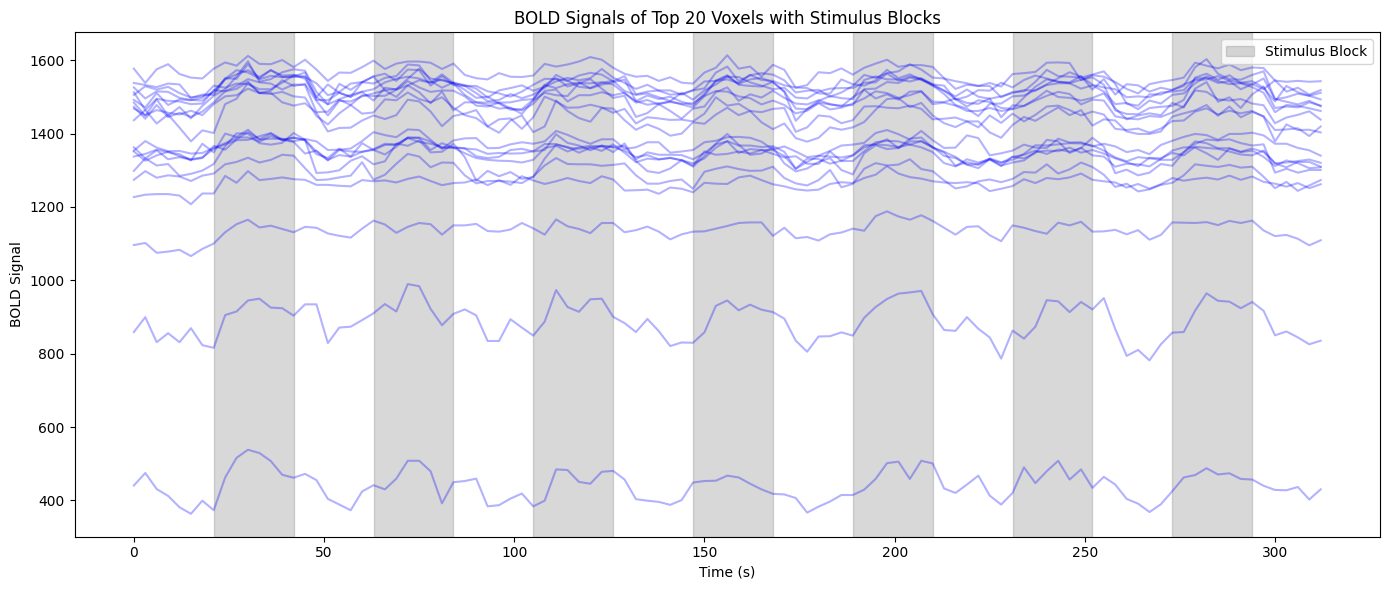

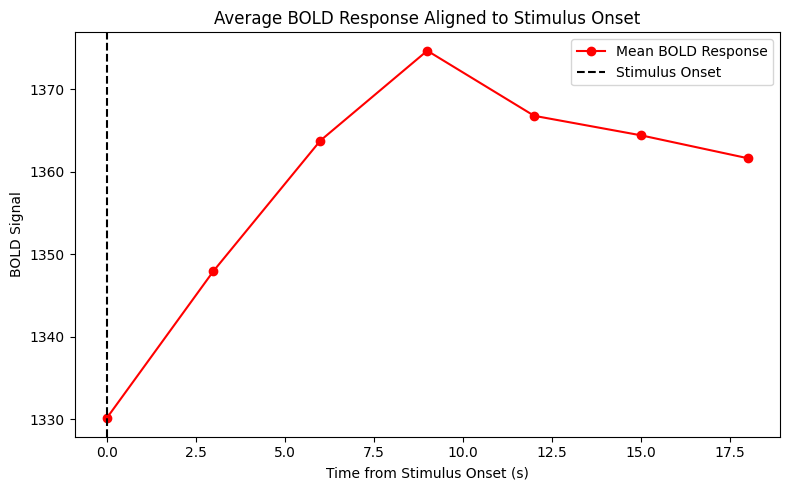

In [27]:
# 提取前20个显著体素的时间序列
top_voxels_signals = bold_2d[top_20_indices, :]

# 转换TR到时间（秒）
time_points = np.arange(t) * 3  # 每个TR=3秒

# 生成刺激期的时间块标记
stim_blocks = []
for i in range(7):
    start_tr = 7 + i * 14  # 每个刺激块的起始TR
    stim_blocks.append((start_tr * 3, (start_tr + 7) * 3))  # 转换为秒

# 绘制所有体素的信号叠加图
plt.figure(figsize=(14, 6))
plt.title("BOLD Signals of Top 20 Voxels with Stimulus Blocks")
plt.xlabel("Time (s)")
plt.ylabel("BOLD Signal")

# 绘制每个体素的信号（半透明叠加）
for signal in top_voxels_signals:
    plt.plot(time_points, signal, alpha=0.3, color='blue')

# 用灰色背景标注刺激期
for (start, end) in stim_blocks:
    plt.axvspan(start, end, color='gray', alpha=0.3, label="Stimulus Block" if start == stim_blocks[0][0] else "")

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 绘制平均刺激响应曲线（事件相关平均）
plt.figure(figsize=(8, 5))
plt.title("Average BOLD Response Aligned to Stimulus Onset")
plt.xlabel("Time from Stimulus Onset (s)")
plt.ylabel("BOLD Signal")

# 对齐所有刺激块的信号并计算平均
aligned_signals = []
for i in range(7):
    start_tr = 7 + i * 14
    aligned_signals.append(top_voxels_signals[:, start_tr:start_tr+7].mean(axis=0))  # 每个块7个TR

mean_aligned = np.mean(aligned_signals, axis=0)
time_aligned = np.arange(7) * 3  # 0-21秒对齐到刺激起始

plt.plot(time_aligned, mean_aligned, marker='o', linestyle='-', color='red', label="Mean BOLD Response")
plt.axvline(0, color='black', linestyle='--', label="Stimulus Onset")
plt.legend()
plt.tight_layout()
plt.show()

# 把top 20 voxels画在MRI T1结构像相应的slice上

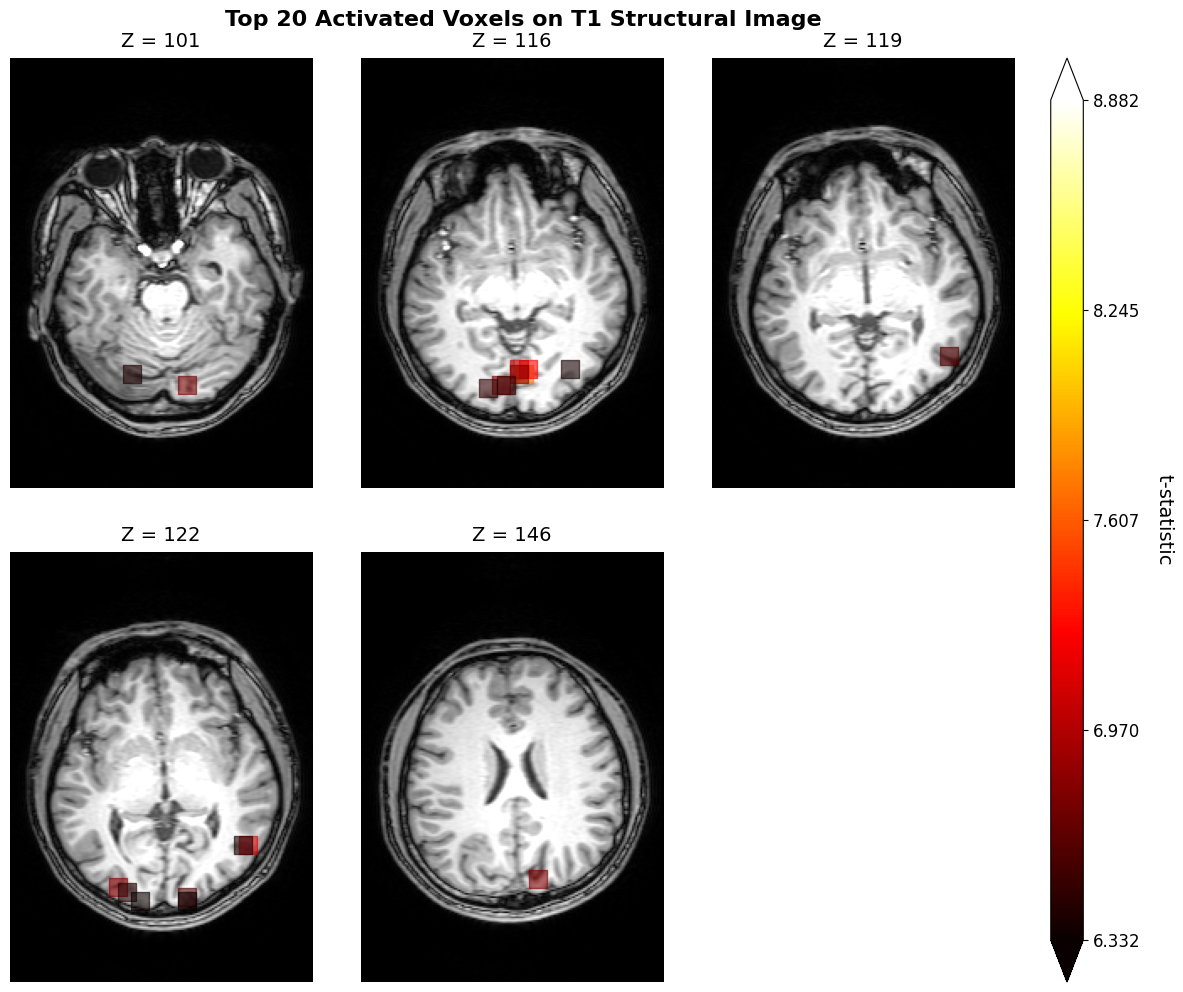

In [28]:
from matplotlib.colors import Normalize

# 收集top20体素的T1坐标和t值
top_voxels_t1 = []
for idx in top_20_indices:
    # 获取BOLD体素坐标
    i, j, k = np.unravel_index(idx, bold_data.shape[:-1])

    # 转换到MNI坐标
    mni = xyz2mni(bold_raw.affine, (i, j, k))

    # 转换到T1体素坐标
    xyz_t1 = mni2xyz(t1_raw.affine, mni)
    x_t1, y_t1, z_t1 = np.round(xyz_t1).astype(int)

    # 检查坐标有效性
    if (x_t1 >= 0 and y_t1 >= 0 and z_t1 >= 0 and
        x_t1 < t1_data.shape[0] and
        y_t1 < t1_data.shape[1] and
        z_t1 < t1_data.shape[2]):

        top_voxels_t1.append({
            'coord': (x_t1, y_t1, z_t1),
            't_stat': t_stat[idx]
        })

# 提取所有唯一的z切片
unique_z = np.unique([v['coord'][2] for v in top_voxels_t1])
n_slices = len(unique_z)

# 计算子图布局
cols = 3
rows = (n_slices + cols - 1) // cols

# 创建颜色映射
norm = Normalize(vmin=np.min(t_stat[top_20_indices]), vmax=np.max(t_stat[top_20_indices]))
cmap = plt.cm.hot

# 创建图形和子图（调整整体尺寸和布局比例）
fig = plt.figure(figsize=(14, 6 * rows))  # 调整高度为6*rows
gs = fig.add_gridspec(
    rows, cols + 1,
    width_ratios=[1]*cols + [0.1]  # 主图:颜色条 = 1:0.1
)

# 绘制每个包含激活体素的切片
for idx, z in enumerate(unique_z):
    ax = fig.add_subplot(gs[idx // cols, idx % cols])
    
    # 获取当前切片的T1图像（轴位）
    slice_data = t1_data[:, :, z].T
    ax.imshow(slice_data, cmap='gray', origin='lower', 
             vmin=np.percentile(t1_data, 10),  # 动态调整对比度
             vmax=np.percentile(t1_data, 99.5))
    
    # 绘制当前切片的激活体素（调整点样式）
    slice_voxels = [v for v in top_voxels_t1 if v['coord'][2] == z]
    for voxel in slice_voxels:
        x, y, _ = voxel['coord']
        color = cmap(norm(voxel['t_stat']))
        ax.scatter(
            x, y, 
            c=[color],
            marker='s',
            s=150,
            alpha=0.6
        )
    
    # 调整标题和标签
    ax.set_title(f"Z = {z}", fontsize=14, pad=8)  # 增大标题字体
    ax.axis('off')

# 添加优化后的颜色条
cbar_ax = fig.add_subplot(gs[:, -1])
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    orientation='vertical',
    extend='both',
    ticks=np.linspace(norm.vmin, norm.vmax, 5)  # 5个刻度
)
cbar.ax.tick_params(labelsize=12)            # 增大刻度字体
cbar.set_label('t-statistic', 
               fontsize=14, 
               labelpad=10, 
               rotation=270, 
               va='bottom')

# 调整总标题和布局
plt.suptitle("Top 20 Activated Voxels on T1 Structural Image", 
             y=0.92,  # 调整标题位置
             fontsize=16, 
             fontweight='bold')
plt.subplots_adjust(wspace=0.1, hspace=0.15)  # 调整子图间距
plt.show()

# 相关分析

In [29]:
from scipy.stats import t as t_dist
x, y, z, t = bold_data.shape

# 构造参考信号（刺激期=1，基线期=0）
reference = np.zeros(t)
stim_trs = []
for i in range(7):
    start = 7 + i * 14  # 每个刺激块起始TR
    stim_trs.extend(range(start, start + 7))
reference[stim_trs] = 1

# 计算皮尔逊相关系数和p值
mean_bold = bold_2d.mean(axis=1, keepdims=True)
std_bold = bold_2d.std(axis=1, keepdims=True)
norm_bold = (bold_2d - mean_bold) / std_bold
mean_ref = reference.mean()
std_ref = reference.std()
norm_ref = (reference - mean_ref) / std_ref
correlations = norm_bold.dot(norm_ref) / (t - 1)
df = t - 2
r_squared = correlations ** 2
t_values = correlations * np.sqrt(df / (1 - r_squared))
p_values = 2 * (1 - t_dist.cdf(np.abs(t_values), df))

# 按p值排序并取前20
sorted_indices = np.argsort(p_values)
top_20_indices = sorted_indices[:20]

# 转换坐标到MNI空间
mni_coords = []
for idx in top_20_indices:
    i, j, k = np.unravel_index(idx, (x, y, z))
    mni = xyz2mni(bold_raw.affine, (i, j, k))
    mni_coords.append(mni)

# 输出结果
print("Top 20 activated voxels in MNI coordinates (correlation method):")
for coord in mni_coords:
    print(f"[{coord[0]:.2f}, {coord[1]:.2f}, {coord[2]:.2f}]")

corr_coords = np.array(mni_coords)

Top 20 activated voxels in MNI coordinates (correlation method):
[6.81, -61.72, 0.75]
[6.69, -64.47, 0.81]
[9.55, -61.84, 0.60]
[51.50, -52.55, 4.18]
[4.07, -61.60, 0.89]
[13.88, -70.62, -14.48]
[-26.38, -73.89, 8.78]
[16.29, -69.73, 30.44]
[3.95, -64.35, 0.95]
[14.54, -81.19, 6.73]
[-7.26, -69.36, 1.65]
[51.22, -55.35, 1.24]
[-15.61, -71.74, 2.15]
[-4.52, -69.48, 1.51]
[-18.80, -63.68, -12.87]
[14.42, -83.94, 6.79]
[48.75, -52.43, 4.32]
[-21.01, -76.88, 8.55]
[0.41, -75.33, -4.65]
[-32.17, -54.84, -12.33]


C:\Users\ItzFriiz\AppData\Local\Temp\ipykernel_19544\3672358561.py:15: RuntimeWarning: invalid value encountered in divide
  norm_bold = (bold_2d - mean_bold) / std_bold


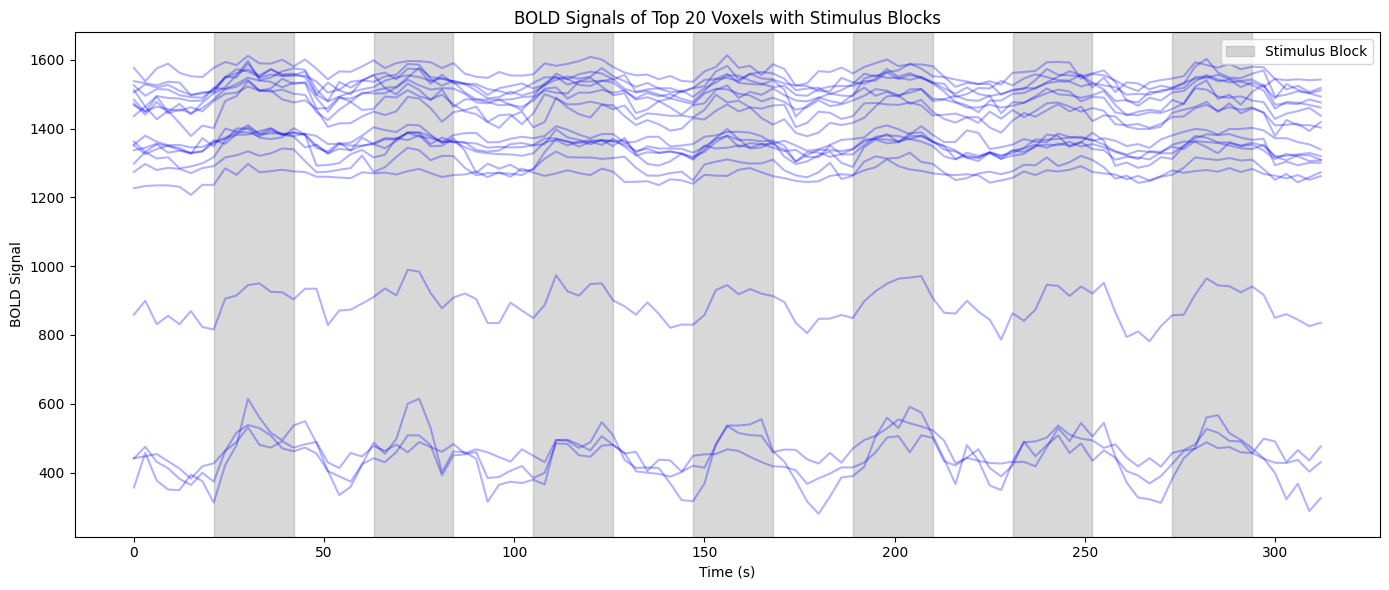

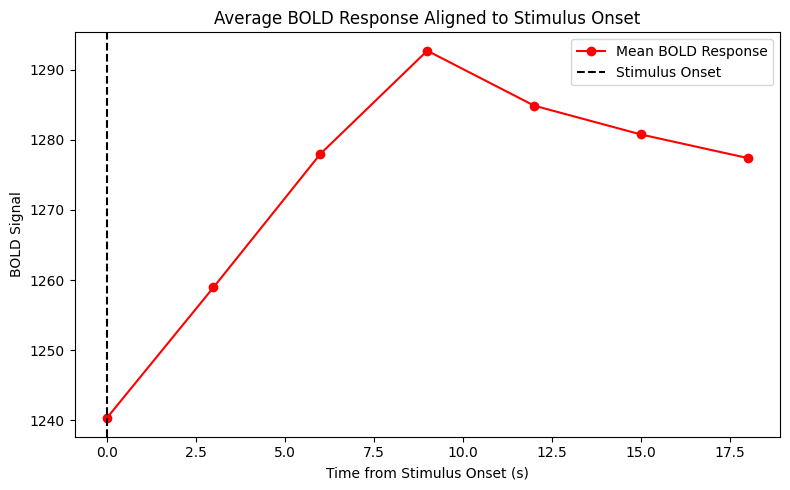

In [30]:
# 提取前20个显著体素的时间序列
top_voxels_signals = bold_2d[top_20_indices, :]

# 转换TR到时间（秒）
time_points = np.arange(t) * 3  # 每个TR=3秒

# 绘制所有体素的信号叠加图
plt.figure(figsize=(14, 6))
plt.title("BOLD Signals of Top 20 Voxels with Stimulus Blocks")
plt.xlabel("Time (s)")
plt.ylabel("BOLD Signal")

# 绘制每个体素的信号（半透明叠加）
for signal in top_voxels_signals:
    plt.plot(time_points, signal, alpha=0.3, color='blue')

# 用灰色背景标注刺激期
for (start, end) in stim_blocks:
    plt.axvspan(start, end, color='gray', alpha=0.3, label="Stimulus Block" if start == stim_blocks[0][0] else "")

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 绘制平均刺激响应曲线（事件相关平均）
plt.figure(figsize=(8, 5))
plt.title("Average BOLD Response Aligned to Stimulus Onset")
plt.xlabel("Time from Stimulus Onset (s)")
plt.ylabel("BOLD Signal")

# 对齐所有刺激块的信号并计算平均
aligned_signals = []
for i in range(7):
    start_tr = 7 + i * 14
    aligned_signals.append(top_voxels_signals[:, start_tr:start_tr+7].mean(axis=0))  # 每个块7个TR

mean_aligned = np.mean(aligned_signals, axis=0)
time_aligned = np.arange(7) * 3  # 0-21秒对齐到刺激起始

plt.plot(time_aligned, mean_aligned, marker='o', linestyle='-', color='red', label="Mean BOLD Response")
plt.axvline(0, color='black', linestyle='--', label="Stimulus Onset")
plt.legend()
plt.tight_layout()
plt.show()

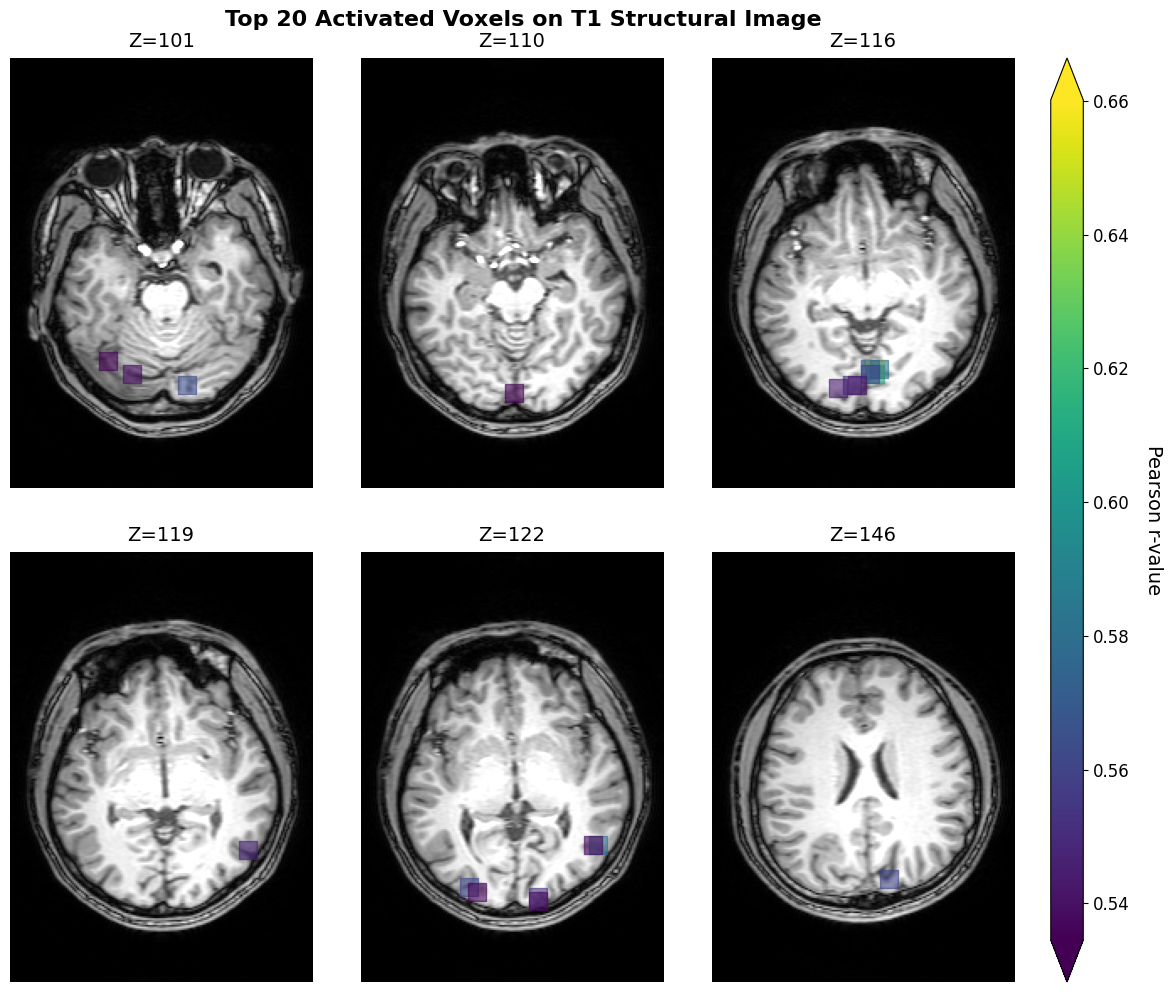

In [31]:
# 收集top20体素的T1坐标和统计量
top_voxels_t1 = []
for idx in top_20_indices:
    # 获取BOLD体素坐标
    i, j, k = np.unravel_index(idx, bold_data.shape[:-1])

    # 转换到MNI坐标
    mni = xyz2mni(bold_raw.affine, (i, j, k))

    # 转换到T1体素坐标
    xyz_t1 = mni2xyz(t1_raw.affine, mni)
    x_t1, y_t1, z_t1 = np.round(xyz_t1).astype(int)

    # 检查坐标有效性
    if (0 <= x_t1 < t1_data.shape[0] and
        0 <= y_t1 < t1_data.shape[1] and
        0 <= z_t1 < t1_data.shape[2]):
        
        top_voxels_t1.append({
            't1_coord': (x_t1, y_t1, z_t1),
            'r_value': correlations[idx]
        })

unique_z = np.unique([v['t1_coord'][2] for v in top_voxels_t1])
n_slices = len(unique_z)
cols = 3
rows = (n_slices + cols - 1) // cols

# 创建颜色映射（基于r值）
r_values = [v['r_value'] for v in top_voxels_t1]
norm = Normalize(vmin=np.min(r_values), vmax=np.max(r_values))
cmap = plt.cm.viridis  # 改用更适合相关系数的色图

# 创建图形和子图（调整整体尺寸和布局比例）
fig = plt.figure(figsize=(14, 6 * rows))  # 调整高度为6*rows
gs = fig.add_gridspec(
    rows, cols + 1,
    width_ratios=[1]*cols + [0.1]  # 主图:颜色条 = 1:0.1
)

for idx, z in enumerate(unique_z):
    ax = fig.add_subplot(gs[idx // cols, idx % cols])
    
    # 获取当前切片的T1图像（轴位）
    slice_data = t1_data[:, :, z].T
    ax.imshow(slice_data, cmap='gray', origin='lower', 
             vmin=np.percentile(t1_data, 10),  # 动态调整对比度
             vmax=np.percentile(t1_data, 99.5))
    
    # 绘制激活点
    slice_voxels = [v for v in top_voxels_t1 if v['t1_coord'][2] == z]
    for voxel in slice_voxels:
        x, y, _ = voxel['t1_coord']
        ax.scatter(x, y, 
                   c=[cmap(norm(voxel['r_value']))],
                   marker='s', s=150, alpha=0.6)
    
    # 设置标签
    ax.set_title(f"Z={z}", fontsize=14, pad=8)
    ax.axis('off')

# 添加颜色条
cbar_ax = fig.add_subplot(gs[:, -1])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax, 
                    orientation='vertical', 
                    extend='both')
cbar.set_label('Pearson r-value', 
               fontsize=14, 
               labelpad=10, 
               rotation=270, 
               va='bottom')
cbar.ax.tick_params(labelsize=12)

# 调整总标题和布局
plt.suptitle("Top 20 Activated Voxels on T1 Structural Image", 
             y=0.92,  # 调整标题位置
             fontsize=16, 
             fontweight='bold')
plt.subplots_adjust(wspace=0.1, hspace=0.15)  # 调整子图间距
plt.show()

# General Linear Model

In [32]:
from numpy.linalg import inv

x, y, z, t = bold_data.shape
bold_2d = bold_data.reshape(-1, t)

# 构造设计矩阵（GLM）
stim_blocks = []
design = np.ones((t, 2))  # 包含截距项
design[:, 1] = 0  # 第二列为刺激条件

for i in range(7):
    start = 7 + i * 14
    design[start:start+7, 1] = 1
    stim_blocks.append((start*3, (start+7)*3))  # 保存刺激块时间范围

# GLM计算
beta = np.dot(inv(np.dot(design.T, design)), np.dot(design.T, bold_2d.T))
residuals = bold_2d.T - np.dot(design, beta)
df = t - 2  # 自由度
mse = np.sum(residuals**2, axis=0) / df
cov_beta = mse * inv(np.dot(design.T, design)).diagonal()[1]
t_values = beta[1, :] / np.sqrt(cov_beta)
p_values = 2 * (1 - t_dist.cdf(np.abs(t_values), df))

# 筛选显著体素
sorted_indices = np.argsort(p_values)
top_20_indices = sorted_indices[:20]

# 转换坐标到MNI空间
mni_coords = []
for idx in top_20_indices:
    i, j, k = np.unravel_index(idx, (x, y, z))
    mni = xyz2mni(bold_raw.affine, (i, j, k))
    mni_coords.append(mni)

# 输出结果
print("Top 20 activated voxels in MNI coordinates (GLM):")
for coord in mni_coords:
    print(f"[{coord[0]:.2f}, {coord[1]:.2f}, {coord[2]:.2f}]")

glm_coords = np.array(mni_coords)

C:\Users\ItzFriiz\AppData\Local\Temp\ipykernel_19544\3869346881.py:22: RuntimeWarning: invalid value encountered in divide
  t_values = beta[1, :] / np.sqrt(cov_beta)


Top 20 activated voxels in MNI coordinates (GLM):
[6.81, -61.72, 0.75]
[6.69, -64.47, 0.81]
[9.55, -61.84, 0.60]
[51.50, -52.55, 4.18]
[4.07, -61.60, 0.89]
[13.88, -70.62, -14.48]
[-26.38, -73.89, 8.78]
[16.29, -69.73, 30.44]
[3.95, -64.35, 0.95]
[14.54, -81.19, 6.73]
[-7.26, -69.36, 1.65]
[51.22, -55.35, 1.24]
[-15.61, -71.74, 2.15]
[-4.52, -69.48, 1.51]
[-18.80, -63.68, -12.87]
[14.42, -83.94, 6.79]
[48.75, -52.43, 4.32]
[-21.01, -76.88, 8.55]
[0.41, -75.33, -4.65]
[-32.17, -54.84, -12.33]


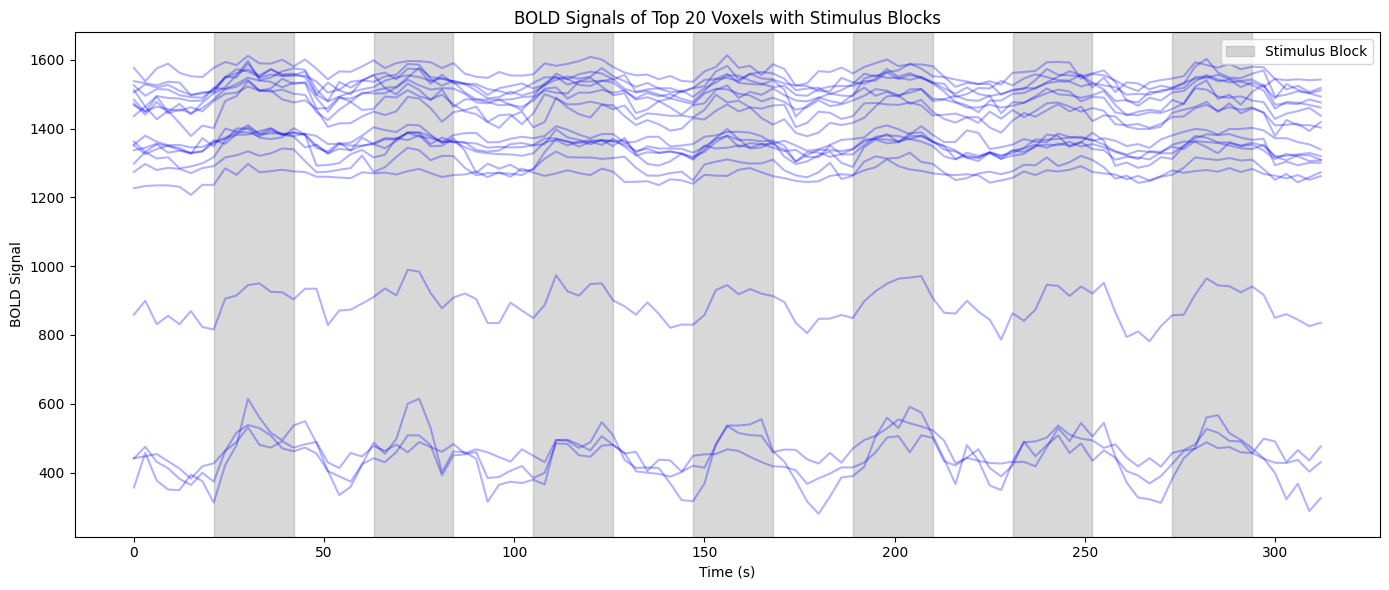

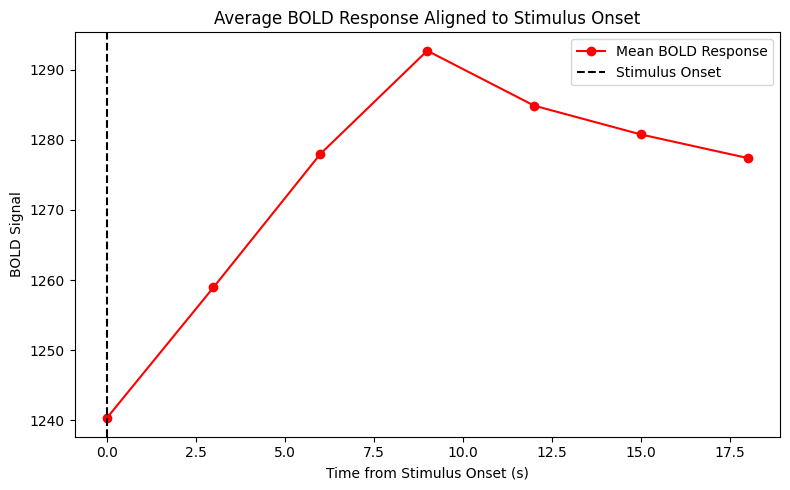

In [33]:
# 提取前20个显著体素的时间序列
top_voxels_signals = bold_2d[top_20_indices, :]

# 转换TR到时间（秒）
time_points = np.arange(t) * 3  # 每个TR=3秒

# 绘制所有体素的信号叠加图
plt.figure(figsize=(14, 6))
plt.title("BOLD Signals of Top 20 Voxels with Stimulus Blocks")
plt.xlabel("Time (s)")
plt.ylabel("BOLD Signal")

# 绘制每个体素的信号（半透明叠加）
for signal in top_voxels_signals:
    plt.plot(time_points, signal, alpha=0.3, color='blue')

# 用灰色背景标注刺激期
for (start, end) in stim_blocks:
    plt.axvspan(start, end, color='gray', alpha=0.3, label="Stimulus Block" if start == stim_blocks[0][0] else "")

plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 绘制平均刺激响应曲线（事件相关平均）
plt.figure(figsize=(8, 5))
plt.title("Average BOLD Response Aligned to Stimulus Onset")
plt.xlabel("Time from Stimulus Onset (s)")
plt.ylabel("BOLD Signal")

# 对齐所有刺激块的信号并计算平均
aligned_signals = []
for i in range(7):
    start_tr = 7 + i * 14
    aligned_signals.append(top_voxels_signals[:, start_tr:start_tr+7].mean(axis=0))  # 每个块7个TR

mean_aligned = np.mean(aligned_signals, axis=0)
time_aligned = np.arange(7) * 3  # 0-21秒对齐到刺激起始

plt.plot(time_aligned, mean_aligned, marker='o', linestyle='-', color='red', label="Mean BOLD Response")
plt.axvline(0, color='black', linestyle='--', label="Stimulus Onset")
plt.legend()
plt.tight_layout()
plt.show()

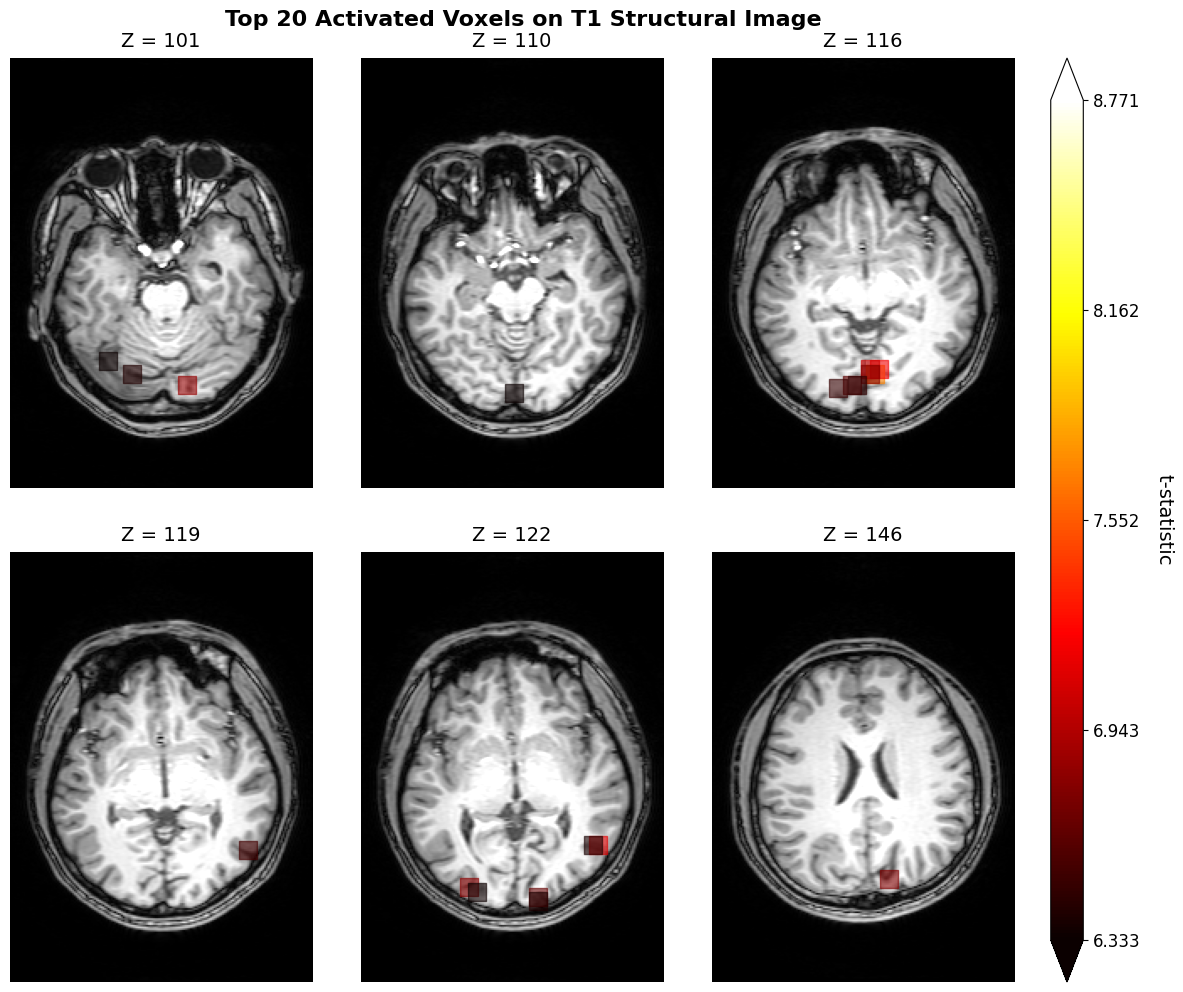

In [34]:
# 收集top20体素的T1坐标和t值
top_voxels_t1 = []
for idx in top_20_indices:
    # 获取BOLD体素坐标
    i, j, k = np.unravel_index(idx, bold_data.shape[:-1])

    # 转换到MNI坐标
    mni = xyz2mni(bold_raw.affine, (i, j, k))

    # 转换到T1体素坐标
    xyz_t1 = mni2xyz(t1_raw.affine, mni)
    x_t1, y_t1, z_t1 = np.round(xyz_t1).astype(int)

    # 检查坐标有效性
    if (x_t1 >= 0 and y_t1 >= 0 and z_t1 >= 0 and
        x_t1 < t1_data.shape[0] and
        y_t1 < t1_data.shape[1] and
        z_t1 < t1_data.shape[2]):

        top_voxels_t1.append({
            'coord': (x_t1, y_t1, z_t1),
            't_values': t_values[idx]
        })

# 提取所有唯一的z切片
unique_z = np.unique([v['coord'][2] for v in top_voxels_t1])
n_slices = len(unique_z)

# 计算子图布局
cols = 3
rows = (n_slices + cols - 1) // cols

# 创建颜色映射
norm = Normalize(vmin=np.min(t_values[top_20_indices]), vmax=np.max(t_values[top_20_indices]))
cmap = plt.cm.hot

# 创建图形和子图（调整整体尺寸和布局比例）
fig = plt.figure(figsize=(14, 6 * rows))  # 调整高度为6*rows
gs = fig.add_gridspec(
    rows, cols + 1,
    width_ratios=[1]*cols + [0.1]  # 主图:颜色条 = 1:0.1
)

# 绘制每个包含激活体素的切片
for idx, z in enumerate(unique_z):
    ax = fig.add_subplot(gs[idx // cols, idx % cols])
    
    # 获取当前切片的T1图像（轴位）
    slice_data = t1_data[:, :, z].T
    ax.imshow(slice_data, cmap='gray', origin='lower', 
             vmin=np.percentile(t1_data, 10),  # 动态调整对比度
             vmax=np.percentile(t1_data, 99.5))
    
    # 绘制当前切片的激活体素（调整点样式）
    slice_voxels = [v for v in top_voxels_t1 if v['coord'][2] == z]
    for voxel in slice_voxels:
        x, y, _ = voxel['coord']
        color = cmap(norm(voxel['t_values']))
        ax.scatter(
            x, y, 
            c=[color],
            marker='s',
            s=150,
            alpha=0.6
        )
    
    # 调整标题和标签
    ax.set_title(f"Z = {z}", fontsize=14, pad=8)  # 增大标题字体
    ax.axis('off')

# 添加优化后的颜色条
cbar_ax = fig.add_subplot(gs[:, -1])
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    orientation='vertical',
    extend='both',
    ticks=np.linspace(norm.vmin, norm.vmax, 5)  # 5个刻度
)
cbar.ax.tick_params(labelsize=12)            # 增大刻度字体
cbar.set_label('t-statistic', 
               fontsize=14, 
               labelpad=10, 
               rotation=270, 
               va='bottom')

# 调整总标题和布局
plt.suptitle("Top 20 Activated Voxels on T1 Structural Image", 
             y=0.92,  # 调整标题位置
             fontsize=16, 
             fontweight='bold')
plt.subplots_adjust(wspace=0.1, hspace=0.15)  # 调整子图间距
plt.show()

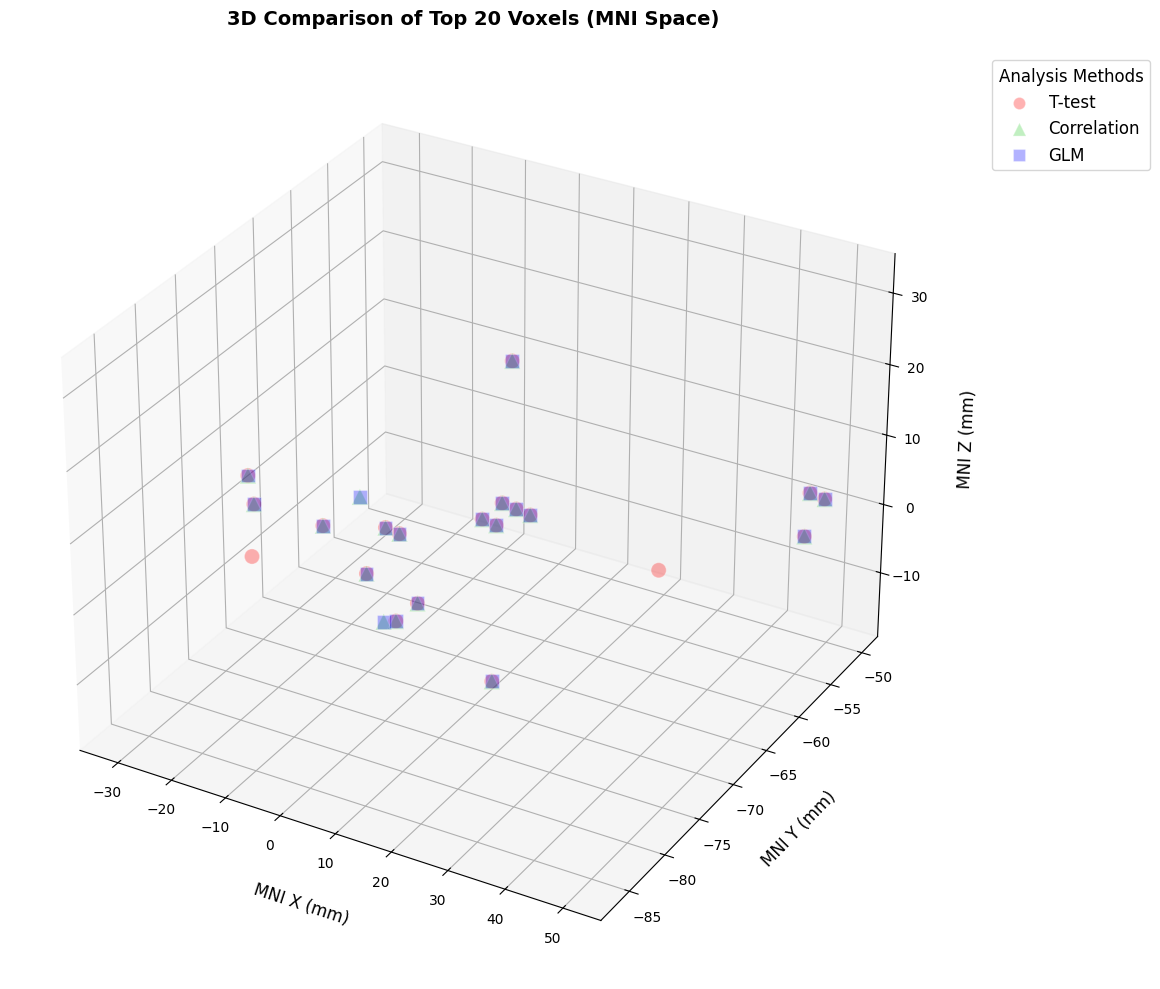

In [35]:
# 创建3D坐标轴
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图（不同形状+颜色组合）
scatter_t = ax.scatter(
    t_coords[:,0], t_coords[:,1], t_coords[:,2],
    c='red', marker='o', s=120, alpha=0.3,  # 圆形
    edgecolor='w', linewidth=0.8, label='T-test'
)

scatter_corr = ax.scatter(
    corr_coords[:,0], corr_coords[:,1], corr_coords[:,2],
    c='limegreen', marker='^', s=140, alpha=0.3,  # 三角形
    edgecolor='w', linewidth=0.8, label='Correlation'
)

scatter_glm = ax.scatter(
    glm_coords[:,0], glm_coords[:,1], glm_coords[:,2],
    c='blue', marker='s', s=100, alpha=0.3,  # 正方形
    edgecolor='w', linewidth=0.8, label='GLM'
)

# 设置坐标轴属性
ax.set_xlabel("MNI X (mm)", fontsize=12, labelpad=15)
ax.set_ylabel("MNI Y (mm)", fontsize=12, labelpad=15)
ax.set_zlabel("MNI Z (mm)", fontsize=12, labelpad=15)
ax.set_title("3D Comparison of Top 20 Voxels (MNI Space)", 
             fontsize=14, pad=20, fontweight='bold')

# 自动设置坐标轴范围（加5mm边距）
all_coords = np.vstack([t_coords, corr_coords, glm_coords])
x_range = (np.min(all_coords[:,0])-5, np.max(all_coords[:,0])+5)
y_range = (np.min(all_coords[:,1])-5, np.max(all_coords[:,1])+5)
z_range = (np.min(all_coords[:,2])-5, np.max(all_coords[:,2])+5)

ax.set_xlim(*x_range)
ax.set_ylim(*y_range)
ax.set_zlim(*z_range)

# 设置图例和网格
legend = ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    fontsize=12,
    frameon=True,
    markerscale=0.8,
    title="Analysis Methods"
)
legend.get_title().set_fontsize(12)
ax.grid(True, alpha=0.3)

# 添加交互功能
def on_move(event):
    if event.inaxes == ax:
        ax.view_init(elev=ax.elev, azim=ax.azim)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', on_move)

plt.tight_layout()
plt.show()

# 脑区查询

In [43]:
# Import the AtlasBrowser class
from mni_to_atlas import AtlasBrowser

# Instantiate the AtlasBrowser class and specify the atlas to use
atlas = AtlasBrowser("AAL3")

# Provide MNI coordinates as an (n x 3) array
coordinates = glm_coords

# Find the brain regions at the MNI coordinates (plotting is optional)
regions = atlas.find_regions(coordinates, plot=False)
print(regions)

['Lingual_R', 'Lingual_R', 'Lingual_R', 'Temporal_Mid_R', 'Undefined', 'Cerebellum_6_R', 'Undefined', 'Cuneus_R', 'Lingual_R', 'Calcarine_R', 'Lingual_L', 'Temporal_Mid_R', 'Lingual_L', 'Lingual_L', 'Lingual_L', 'Calcarine_R', 'Undefined', 'Undefined', 'Undefined', 'Fusiform_L']
